# Experiment 2: Acquiring time-domain IQ data 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from flux_fit import *
from utils import *

In [5]:
!python -m srsinst.dc205

## Setting up the Experiment

Setup the project and experiment names

In [70]:
project_name = "Andreev_Spectroscopy"
device_name = "L1A"
run_id = 1
T_MXC = 30
T_Rad = None
experiment_name = f"{device_name}_IQ{run_id}_V_0p02"

drive_path = r"E:\Quasiparticles"
data_path = set_project(r"{}\{}".format(drive_path, project_name), f"{experiment_name}")

# Constants
SPATH = data_path
FIG_PATH = os.path.join(SPATH, "Figures")
LOG_FILE = os.path.join(SPATH, f'MEASUREMENTLOG_{time.strftime("%Y%m%d_%H%M%S")}.log')
PATH_TO_EXE = r'C:/Users/LFL/lflPython/AlazarDrivers/CS_Average/x64/Release/ATS9371_CS_Average.exe'

# Ensure directories exist
os.makedirs(FIG_PATH, exist_ok=True)

# Setup logging
logging.basicConfig(filename=LOG_FILE, filemode='w', level=logging.INFO)

Project path set to: E:\Quasiparticles\Andreev_Spectroscopy\051525\L1A_IQ1_V_0p02


### Instrument Setup

Connect to the Labber server and initialize the instruments needed for the experiment

In [7]:
client = Labber.connectToServer(timeout=None)
instrument_list = client.getListOfInstruments()
instruments = create_instrument_connections(client, instrument_list)

Successfully connected to Agilent Network Analyzer E5071B
Successfully connected to HP Spectrum Analyzer
Successfully connected to Keithley 2400 SourceMeter
Successfully connected to Manual
Successfully connected to Rohde&Schwarz RF Source
Successfully connected to SignalCore SC5511A Signal Generator_10002F25_LO
Successfully connected to SignalCore SC5511A Signal Generator_1000334A_TWPA
Successfully connected to Vaunix Lab Brick Digital Attenuator


Instantiate the SRS at the correct range

In [8]:
mode="serial"
channel='COM3'
ID=115200

In [9]:
vs = DC205(mode,channel,ID)

In [10]:
vs.check_id()

('DC205', 's/n20500691', 'ver1.80')

In [11]:
vs.config.voltage_range='range100'

In [12]:
VNA = instruments['Agilent Network Analyzer E5071B']
DA = instruments['Vaunix Lab Brick Digital Attenuator']
SMU = instruments['Keithley 2400 SourceMeter']
LO= instruments['SignalCore SC5511A Signal Generator_10002F25_LO']
TWPA_PUMP= instruments['SignalCore SC5511A Signal Generator_1000334A_TWPA']
Drive = instruments['Rohde&Schwarz RF Source']

In [13]:
initialize_instruments(VNA, DA, SMU, LO, Drive, vs, TWPA_PUMP)

Make sure that the instruments are set to the correct state.

- The TWPA pump is set to the correct frequency and power
- The SRS is set to the correct voltage
- The LO is set to the correct frequency and power
- The VNA is turned off
- The Alazar is configured to acquire the correct number of traces, with the correct acquisition length, sample rate, and average time cycle.

In [ ]:
set_TWPA_pump(f=5.965, power=5.5)

## Setting the experiment parameters

We want to bias the resonator at a certain voltage and drive it at a certain frequency.

In [ ]:
flux_data = load_flux_quanta_analysis('flux_quanta_analysis.json')

In [14]:
phi_values = [0.49]  # Example phi values

In [ ]:
# Specify phi values of interest (normalized flux)
phi_values = [0.45]  # Example phi values

phi_results = plot_phi_points(flux_data, phi_values)
guess_data = process_phi_results(phi_results)

In [ ]:
phi = guess_data['quantum_1']['phi']
voltage = guess_data['quantum_1']['voltage']*1e-3 # Convert to V
guess_frequency = guess_data['quantum_1']['frequency']*1e-9 # Convert to GHz
best_fit = flux_data['quanta']['quantum_1']['best_fit']

In [71]:
import time
LABBER_LOG = r"G:\Shared drives\Labber\Data\{}\{}\Data_{}\\".format(time.strftime("%Y"), time.strftime("%m"), time.strftime("%m%d"))

lfVNA = Labber.createLogFile_ForData(os.path.join(SPATH, f'{device_name}_{project_name}_run-{run_id}_traces'),
                                      [{'name':'VNA - S21','complex':True,'vector':True,'x_name':'Frequency','x_unit':'Hz'}],
                                      step_channels=[{'name':'Phi','values':phi_values,'unit':'flux quanta'}])
initialize_logging(lfVNA, SPATH, PATH_TO_EXE, FIG_PATH, experiment_name, device_name)

Get the accurate frequency of the resonator at the desired flux point. The idea is to sweep the SRS voltage to the required voltage and take a snapshot of the VNA at the guessed frequency and update the frequency to set the LO tone

In [ ]:
electrical_delay = VNA.getValue('Electrical Delay')

In [ ]:
electrical_delay

We have done some rough analysis and found that the QP induced frequency shift is roughly 0.5 MHz so this is what we are going to set as the detuning.


In [ ]:
vna_power = 5
vna_avg = 20
span = 20e6 # Hz
detuning = 0 # Hz


Flux-bias the resonator

In [ ]:
old_range = (-0.070, 0.007)   # in volts
old_R = 46                 # in ohms
new_R = 10000                # in ohms
old_rate = 5E-5               # V/s

# Scale while preserving power/energy
new_range = scale_voltage_range(old_range, old_R, new_R, invariant='current')
new_rate = scale_sweep_rate(old_rate, old_R, new_R, invariant='current')

print(f"New voltage range: {new_range[0]:.3f} V to {new_range[1]:.3f} V")
print(f"New sweep rate: {new_rate:.4f} V/s")

In [72]:
set_flux_bias_srs_in_V(0.02, step = 0.001)

Setting FFL bias to 0.02 V from 0.015 V


In [ ]:
set_flux_bias_srs_in_V(0.25, step = 0.01)

In [ ]:
VNA.setValue('Wait for new trace', True)
VNA.setValue('Trigger', True)

In [ ]:
DA.setValue('Attenuation', 20)

In [ ]:
dBG = VNA.getValue('S21')
xBG = np.arange(dBG['t0'],dBG['t0']+dBG['shape'][0]*dBG['dt'],dBG['dt'])
zBG = dBG['y']
plt.plot(zBG)
plt.show()

Setting the LO and turning off the VNA

In [ ]:
turn_off_LO()

In [ ]:
f_phi, f_drive = find_resonance(phi, span, best_fit, vna_power, vna_avg, electrical_delay, detuning, show_plot=True, f_guess=guess_frequency)

In [16]:
f_drive=5.722890e9
f_phi=5.722890e9
f_d_power = 16

In [73]:
phi=0.49
voltage=0.02

We are not sending in any clearing tone for this experiment.

In [124]:
f_clearing, P_clearing = 16, -11


In [18]:
f_clearing, P_clearing = None, None
#turn_off_clearing()

Now set the Alazar parameters and acquire the IQ data

In [20]:
num_traces=1
acquisitionLength_sec=20
origRateMHz=300
sampleRateMHz=10
averageTimeCycle=0
lowerBound=30 # dB for DA attenuator
upperBound=30# dB for DA attenuator

In [74]:
set_LO_tone(f_drive, f_d_power)
turn_off_vna()

LO tone set to 5.722890 GHz


In [75]:
logging.info(f'\nStarting Alazar acquisition at phi = {phi:.3f} while driving at {f_drive:.6f} GHz')
metadata_files = acquire_IQ_data(phi, f_clearing, P_clearing, num_traces, acquisitionLength_sec, origRateMHz, sampleRateMHz, averageTimeCycle, lowerBound, upperBound)

# Update metadata for all files
for metadata_file in metadata_files:
    write_metadata(metadata_file, acquisitionLength_sec, origRateMHz, f_drive, voltage, T_MXC, T_Rad, phi, f_clearing, P_clearing)

100%|██████████| 1/1 [00:24<00:00, 24.20s/it]


In [79]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import fitTools.quasiparticleFunctions as qp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import glob
from typing import List, Tuple, Optional, Union, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
import pickle

#from gmm_analysis import *

In [81]:
DATA_DIR = r"E:\Quasiparticles\Andreev_Spectroscopy\051525"

In [83]:
files = glob.glob(os.path.join(DATA_DIR, "**", "phi_0p490","**", "*.bin"), recursive=True)
files

['E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_0\\phi_0p490\\DA30_SR10\\L1A_20250515_111442.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_0p005\\phi_0p490\\DA30_SR10\\L1A_20250515_111653.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_0p01\\phi_0p490\\DA30_SR10\\L1A_20250515_112139.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_0p015\\phi_0p490\\DA30_SR10\\L1A_20250515_112416.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_0p02\\phi_0p490\\DA30_SR10\\L1A_20250515_112625.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_n0.02\\phi_0p490\\DA30_SR10\\L1A_20250515_110037.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_n0p005\\phi_0p490\\DA30_SR10\\L1A_20250515_111231.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_n0p01\\phi_0p490\\DA30_SR10\\L1A_20250515_110948.bin',
 'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_n0p015\

In [84]:
files[0]

'E:\\Quasiparticles\\Andreev_Spectroscopy\\051525\\L1A_IQ1_V_0\\phi_0p490\\DA30_SR10\\L1A_20250515_111442.bin'

In [85]:
v_array=[0,0.005,0.01,0.015,0.02,-0.02,-0.005,-0.01,-0.015]

In [89]:
intTime = 2
sampleRatefromData = 10 

C:\Users\LFL\AppData\Local\Temp\ipykernel_26508\3050261771.py:42: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


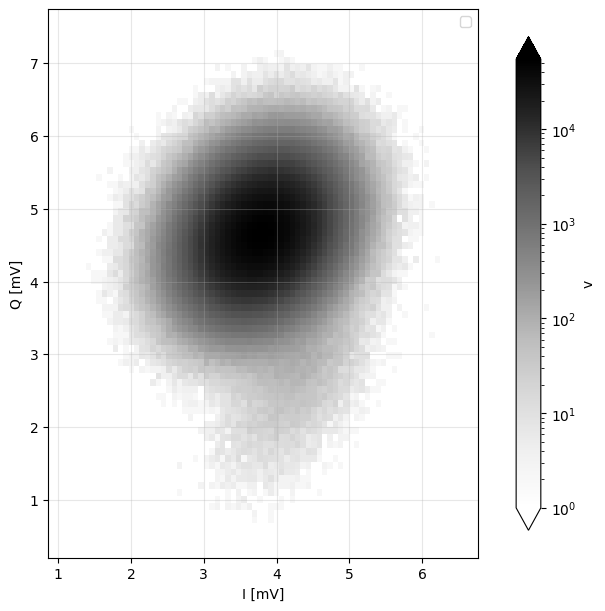

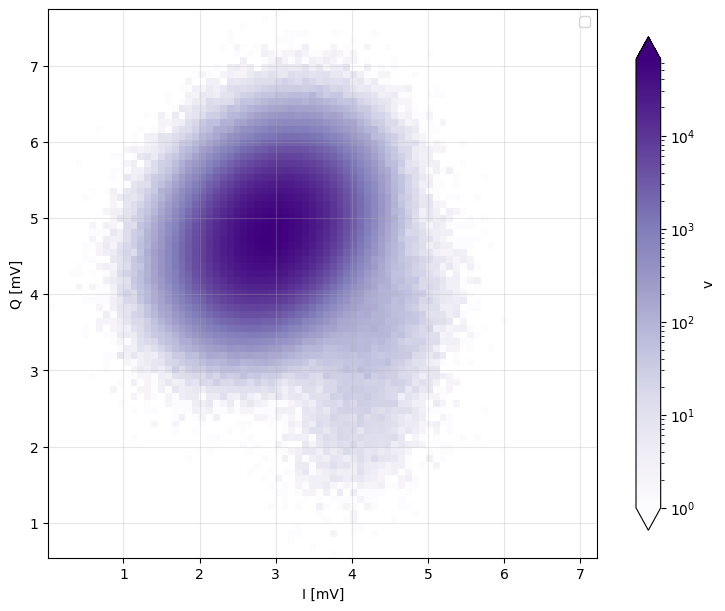

In [ ]:
def plotComplexHist(I,Q,color,v,bins=(80,80),figsize=[9,6],returnHistData=False,):
    '''From I and Q data, plot a greyscale log histogram in complex plane.
    
    returns a pyplot subplot for further modification.
    ----------------------------------------------------
    I:          1 dim data array.
    Q:          data array with same size aas I
    bins:       (a,b) where a is # bins along I and b is along Q
    figsize:    passed to pyplot.figure to set figure size
    ----------------------------------------------------
    
    Example:
    h = plotComplexHist(DATA[:,0],DATA[:,1])
    h.set_xlabel('I [mV]')
    h.set_ylabel('Q [mV]')
    h.set_title('test')
    plt.savefig(r'path/to/save.png')
    '''
    fig =plt.figure(figsize=figsize,constrained_layout=True)
    h = fig.add_subplot()
    hs = plt.hist2d(I,Q,bins=bins,norm=LogNorm(),cmap=plt.get_cmap(color),label=f"v")
    hb = plt.colorbar(hs[-1], shrink=0.9, extend='both',label=f"v")
    h.grid()
    h.set_aspect('equal')
    if returnHistData:
        return h, hs
    return h

color=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

for i in range(2):
    file = files[i]
    v = v_array[i]
    data_og = qp.loadAlazarData(files[i])
    data_downsample, sr = qp.BoxcarDownsample(data_og, intTime, sampleRatefromData, returnRate=True,)
    data_ds_mV = qp.uint16_to_mV(data_downsample)
    ax = plotComplexHist(data_ds_mV[0],data_ds_mV[1],color=color[i],v=v)
    ax.set_xlabel("I [mV]")
    ax.set_ylabel("Q [mV]")
    #ax.set_xlim(0, 8)
    #ax.set_ylim(0, 9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.legend()  

    # Show the plot
    plt.plot()
plt.show()    

In [99]:
color=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

C:\Users\LFL\AppData\Local\Temp\ipykernel_26508\579116538.py:14: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


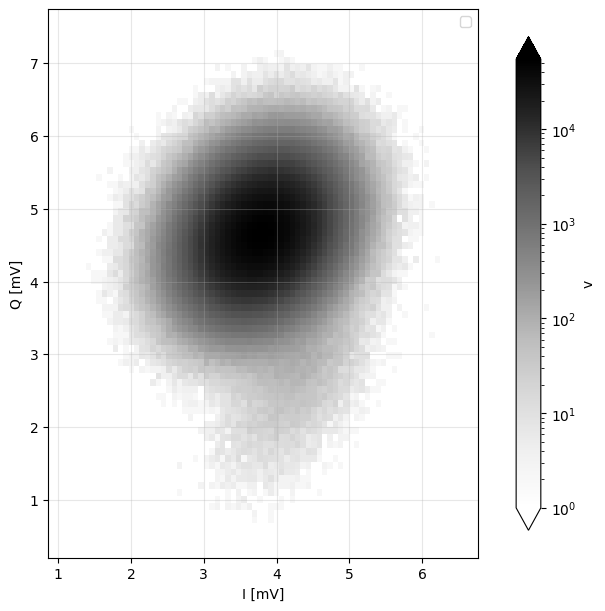

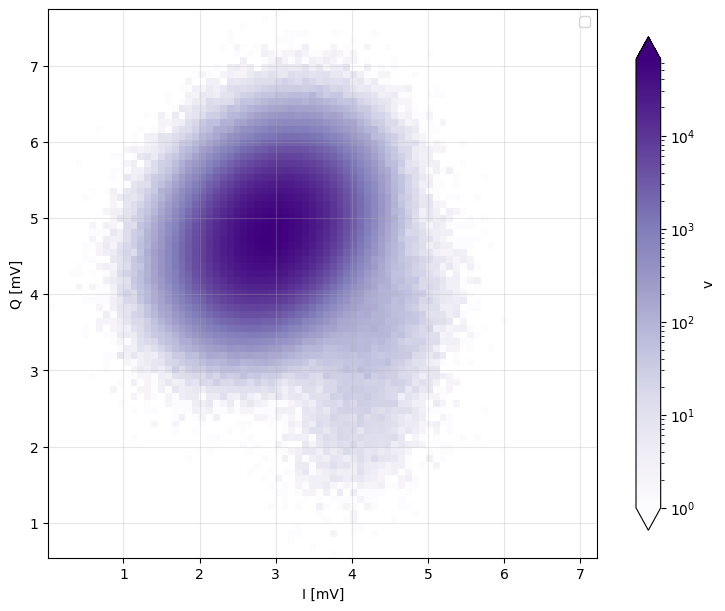

In [106]:
for i in range(2):
    file = files[i]
    v = v_array[i]
    data_og = qp.loadAlazarData(files[i])
    data_downsample, sr = qp.BoxcarDownsample(data_og, intTime, sampleRatefromData, returnRate=True,)
    data_ds_mV = qp.uint16_to_mV(data_downsample)
    ax = plotComplexHist(data_ds_mV[0],data_ds_mV[1],color=color[i],v=v)
    ax.set_xlabel("I [mV]")
    ax.set_ylabel("Q [mV]")
    #ax.set_xlim(0, 8)
    #ax.set_ylim(0, 9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.legend()  

    # Show the plot
    plt.plot()
plt.show()    

In [112]:
color

['Greys',
 'Purples',
 'Blues',
 'Greens',
 'Oranges',
 'Reds',
 'YlOrBr',
 'YlOrRd',
 'OrRd',
 'PuRd',
 'RdPu',
 'BuPu',
 'GnBu',
 'PuBu',
 'YlGnBu',
 'PuBuGn',
 'BuGn',
 'YlGn']

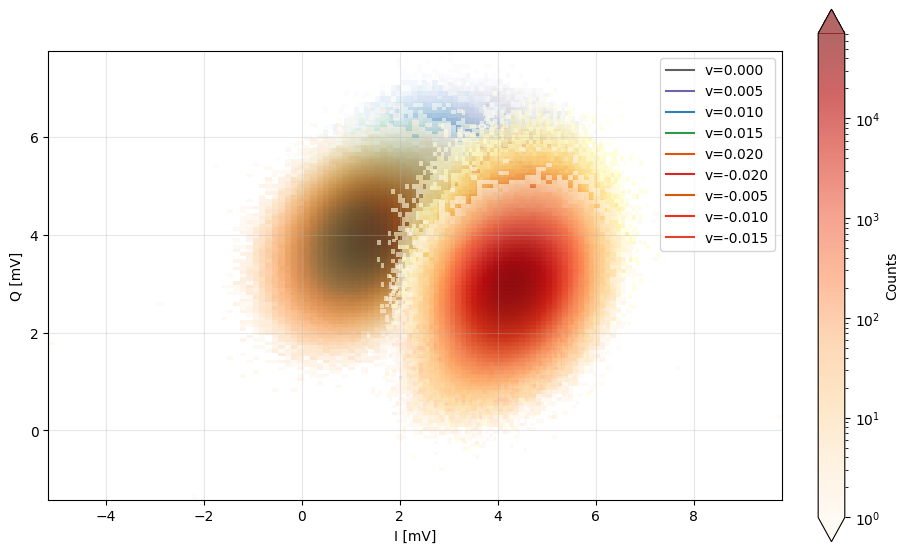

In [ ]:

def plotComplexHist(I, Q, color, v, bins=(80,80), ax=None, returnHistData=False):
    '''From I and Q data, plot a greyscale log histogram in complex plane.'''
    hs = ax.hist2d(I, Q, bins=bins, norm=LogNorm(), cmap=plt.get_cmap(color), alpha=0.6)
    if returnHistData:
        return hs
    # Add a proxy artist for the legend
    ax.plot([], [], color=plt.get_cmap(color)(0.7), label=f"v={v:.3f}")
    return hs

# Find global min/max for all I and Q
I_min, I_max, Q_min, Q_max = np.inf, -np.inf, np.inf, -np.inf
for i in range(len(files)):
    file = files[i]
    data_og = qp.loadAlazarData(file)
    data_downsample, sr = qp.BoxcarDownsample(data_og, intTime, sampleRatefromData, returnRate=True)
    data_ds_mV = qp.uint16_to_mV(data_downsample)
    I_min = min(I_min, np.min(data_ds_mV[0]))
    I_max = max(I_max, np.max(data_ds_mV[0]))
    Q_min = min(Q_min, np.min(data_ds_mV[1]))
    Q_max = max(Q_max, np.max(data_ds_mV[1]))

fig, ax = plt.subplots(figsize=[9,6], constrained_layout=True)

for i in range(len(files)):
    file = files[i]
    v = v_array[i]
    data_og = qp.loadAlazarData(file)
    data_downsample, sr = qp.BoxcarDownsample(data_og, intTime, sampleRatefromData, returnRate=True)
    data_ds_mV = qp.uint16_to_mV(data_downsample)
    plotComplexHist(data_ds_mV[0], data_ds_mV[1], color=color[i], v=v, ax=ax)

ax.set_xlabel("I [mV]")
ax.set_ylabel("Q [mV]")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(I_min, I_max)
ax.set_ylim(Q_min, Q_max)
ax.legend()
plt.colorbar(ax.collections[-1], ax=ax, shrink=0.9, extend='both', label="Counts")
plt.show()


In [114]:
all_data = []

for i in range(len(files)):
    file = files[i]
    v = v_array[i]
    data_og = qp.loadAlazarData(file)
    data_downsample, sr = qp.BoxcarDownsample(data_og, intTime, sampleRatefromData, returnRate=True)
    data_ds_mV = qp.uint16_to_mV(data_downsample)
    all_data.append((data_ds_mV[0], data_ds_mV[1], v))

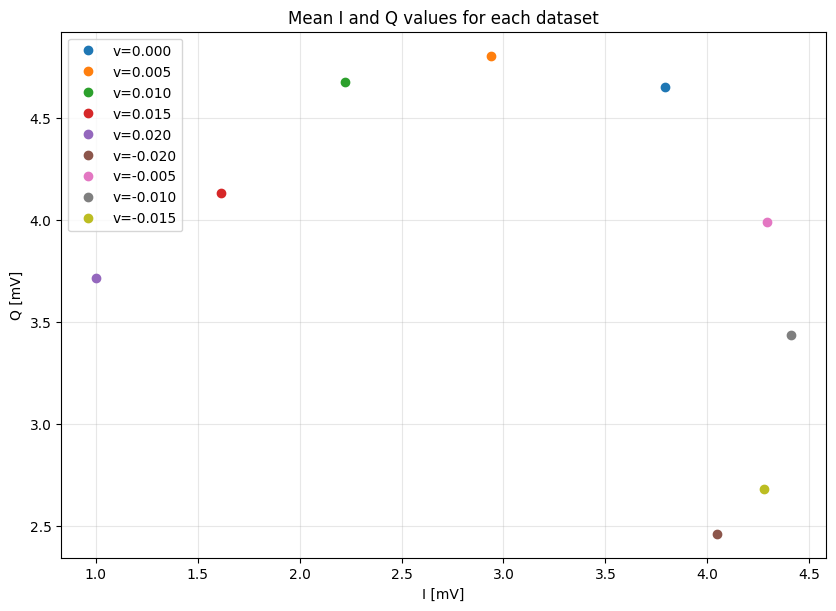

In [ ]:
# plot the means of each dataset in all_data and save the figure, using color and marker to represent v
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=[9,6], constrained_layout=True)

# Normalize v for colormap
v_values = [d[2] for d in all_data]
norm = plt.Normalize(min(v_values), max(v_values))
cmap = cm.get_cmap('coolwarm')

# Use a set of unique markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*']

for i, (I, Q, v) in enumerate(all_data):
    mean_I = np.mean(I)
    mean_Q = np.mean(Q)
    color = cmap(norm(v))
    marker = markers[i % len(markers)]
    ax.plot(mean_I, mean_Q, marker=marker, color=color, label=f"v={v:.3f}", linestyle='None', markersize=10)

ax.set_xlabel("I [mV]")
ax.set_ylabel("Q [mV]")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.legend()
plt.title("Mean I and Q values for each dataset")

# Add colorbar for v
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='v')

plt.savefig(os.path.join(FIG_PATH, "mean_I_Q.png"))
plt.show()

C:\Users\LFL\AppData\Local\Temp\ipykernel_26508\2254082611.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


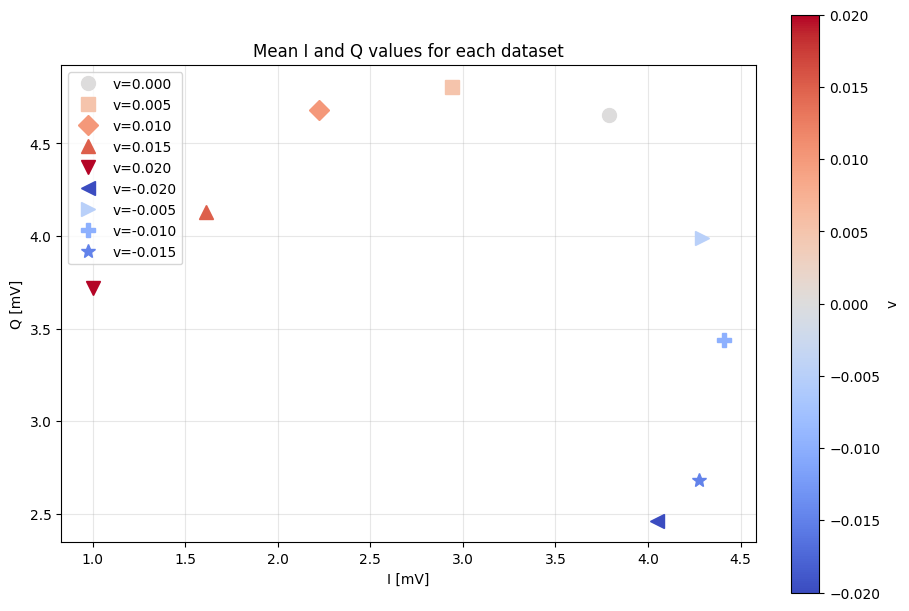

In [ ]:
# plot the means of each dataset in all_data and save the figure, using color and marker to represent v
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=[9,6], constrained_layout=True)

# Normalize v for colormap
v_values = [d[2] for d in all_data]
norm = plt.Normalize(min(v_values), max(v_values))
cmap = cm.get_cmap('coolwarm')

# Use a set of unique markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*']

for i, (I, Q, v) in enumerate(all_data):
    mean_I = np.mean(I)
    mean_Q = np.mean(Q)
    color = cmap(norm(v))
    marker = markers[i % len(markers)]
    ax.plot(mean_I, mean_Q, marker=marker, color=color, label=f"v={v:.3f}", linestyle='None', markersize=10)

ax.set_xlabel("I [mV]")
ax.set_ylabel("Q [mV]")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.legend()
plt.title("Mean I and Q values for each dataset")

# Add colorbar for v
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='v')

plt.savefig(os.path.join(FIG_PATH, "mean_I_Q.png"))
plt.show()

In [127]:
# Drive frequency
drive_freq_GHz = 5.722890

# Flux bias point
flux_bias = 0.05

# Create structured data with voltage, resonance frequency, and offset
data = {
    #'voltage': [-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02],
    #'resonance_GHz': [5.722367, 5.722527, 5.722647, 5.722848, 5.72296, 5.723113, 5.723328, 5.723528, 5.723728],
    "voltage":[0,0.005,0.01,0.015,0.02,-0.02,-0.005,-0.01,-0.015],
    'resonance_GHz': [5.72296,5.723113,5.723328,5.723528,5.723728,5.722367,5.72284,5.722647,5.722527]
    
}

# Convert to numpy arrays for easier manipulation
import numpy as np

voltage = np.array(data['voltage'])
resonance_GHz = np.array(data['resonance_GHz'])

# Calculate all offsets from resonance in kHz
# This computes the difference between each resonance frequency and the drive frequency
offsets_kHz = (resonance_GHz - drive_freq_GHz) * 1e6  # Convert GHz difference to kHz

data['offset_kHz'] = offsets_kHz
# Create a pandas DataFrame for better organization and analysis
import pandas as pd

df = pd.DataFrame({
    'voltage': voltage,
    'resonance_GHz': resonance_GHz,
    'offset_kHz': offsets_kHz,
    'mean_I': [np.mean(data[0]) for data in all_data],
    'mean_Q': [np.mean(data[1]) for data in all_data]
})


df

,voltage,resonance_GHz,offset_kHz,mean_I,mean_Q
0,0.000,5.722960,70.0,3.790303,4.650710
1,0.005,5.723113,223.0,2.941035,4.806789
2,0.010,5.723328,438.0,2.220972,4.677796
3,0.015,5.723528,638.0,1.613664,4.130898
4,0.020,5.723728,838.0,1.001231,3.717415
5,-0.020,5.722367,-523.0,4.047618,2.461487
6,-0.005,5.722840,-50.0,4.290330,3.989232
7,-0.010,5.722647,-243.0,4.412048,3.437543
8,-0.015,5.722527,-363.0,4.275727,2.683266


C:\Users\LFL\AppData\Local\Temp\ipykernel_26508\3528728321.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


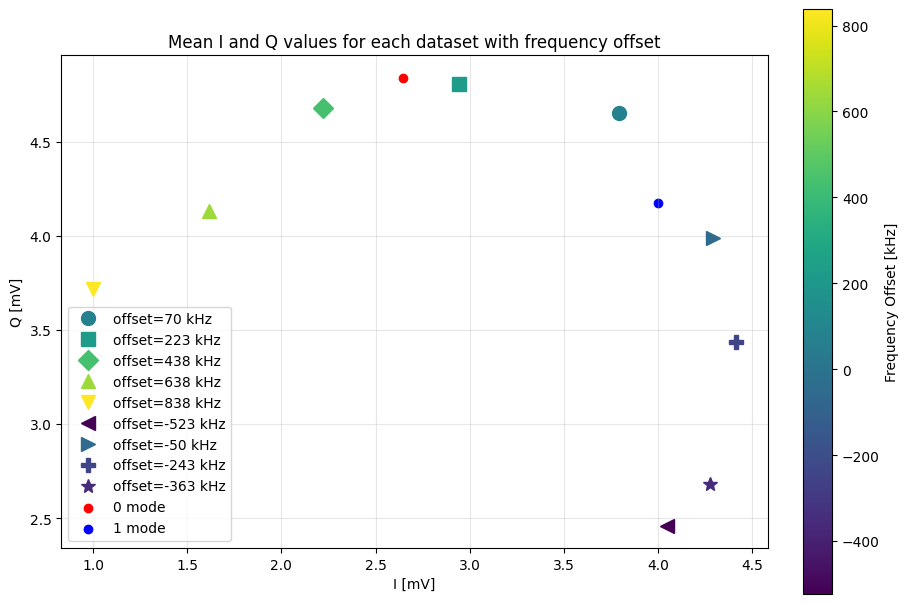

In [132]:
# plot the mean_I and mean_Q scatter plot with color representing offset_kHz
fig, ax = plt.subplots(figsize=[9,6], constrained_layout=True)
# Normalize offset_kHz for colormap
offset_values = df['offset_kHz'].values
norm = plt.Normalize(min(offset_values), max(offset_values))
cmap = cm.get_cmap('viridis')
# Use a set of unique markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*']
for i, (I, Q, offset) in enumerate(zip(df['mean_I'], df['mean_Q'], df['offset_kHz'])):
    color = cmap(norm(offset))
    marker = markers[i % len(markers)]
    ax.plot(I, Q, marker=marker, color=color, label=f"offset={offset:.0f} kHz", linestyle='None', markersize=10)
ax.set_xlabel("I [mV]")
ax.set_ylabel("Q [mV]")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
#ax.legend()
plt.title("Mean I and Q values for each dataset with frequency offset")
# Add colorbar for offset_kHz
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Frequency Offset [kHz]')
plt.savefig(os.path.join(FIG_PATH, "mean_I_Q_offset.png"))
blob_mean=[[2.64473844, 4.84041331],
       [3.99925245, 4.17543859]]
plt.scatter(blob_mean[0][0], blob_mean[0][1], color='red', marker='o', label='0 mode')
plt.scatter(blob_mean[1][0], blob_mean[1][1], color='blue', marker='o', label='1 mode')
ax.legend()
plt.legend()
plt.show()

In [ ]:
from scipy.constants import e, hbar, pi

def expectedShift(q0, f0, ls, phi, delta=170e-6):
    '''Returns the maximum expected shift (tau = 1) due to single quasiparticle
        trapping

    returns df in linear frequency
    -------------------------------
    q0:     participation ratio
    f0:     zero qp resonance at the given flux [in Hz]
    ls:     the Josephson current of nanosquid (Lj/2)
    phi:    reduced flux -- where you're monitoring
    delta:  superconducting gap in eV
    '''
    # TODO: Is this accurate?
    phi0 = hbar/2/e
    return (-q0 * f0 * ls * delta * e *
            (np.cos(pi * phi) + (np.sin(pi * phi / 2)**4)) / 8 /
            (phi0**2) / (1 - (np.sin(pi * phi / 2)**2)))

expectedShift(0.02, 5.7634, ls, 0.49)*1e-3

-6.539977417297426e-05